<a href="https://colab.research.google.com/github/aninsung/Machine-Learning-Programming/blob/main/wisdom(autoencoder).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
# Inspect the first few lines of the file to determine the delimiter and structure
file_path = '/content/drive/MyDrive/기계학습프로그래밍/엑셀파일/WISDM_ar_v1.1_raw.txt'
with open(file_path, 'r') as f:
    for i in range(10): # Read and print the first 10 lines
        print(f.readline())

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;

33,Jogging,49106062271000,5.012288,11.264028,0.95342433;

33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;

33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;

33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;

33,Jogging,49106442306000,1.3756552,-2.4925237,-6.510526;

33,Jogging,49106542312000,-0.61291564,10.56939,5.706926;

33,Jogging,49106652389000,-0.50395286,13.947236,7.0553403;

33,Jogging,49106762313000,-8.430995,11.413852,5.134871;

33,Jogging,49106872299000,0.95342433,1.3756552,1.6480621;



In [3]:
file = open('/content/drive/MyDrive/기계학습프로그래밍/엑셀파일/WISDM_ar_v1.1_raw.txt')
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [4]:
columns = ['user', 'activity', 'time', 'x', 'y', 'z']
df = pd.DataFrame(data = processedList, columns = columns)
df.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [5]:
df.shape

(343416, 6)

In [6]:
# 결측치 홗인

df.isnull().values.any()

np.False_

In [7]:
LABELS = ["Walking ", "Jogging ","Upstairs","Downstairs","Sitting","Standing"]

/tmp/ipython-input-3243703111.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['activity'], sort = True)


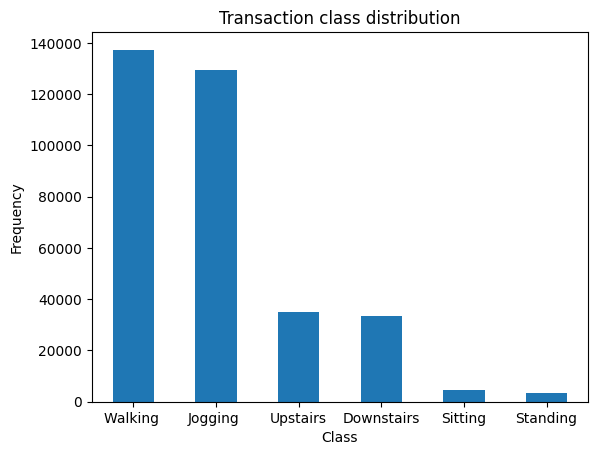

In [8]:
count_classes = pd.value_counts(df['activity'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(6), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [9]:
# Move this cell after the cell that creates the 'Z' column (bxl9EcdX80TC)
frauds = df[df['activity'] == 'Walking']
normal = df[df['activity'] != 'Walking']
frauds.shape

(137375, 6)

In [10]:
normal.shape

(206041, 6)

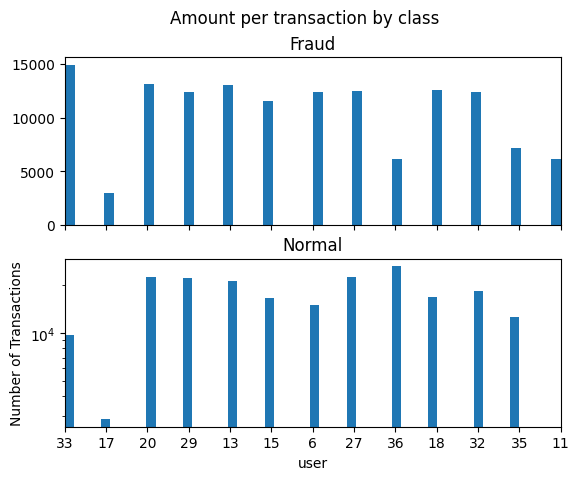

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.user, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.user, bins = bins)
ax2.set_title('Normal')

plt.xlabel('user')
plt.ylabel('Number of Transactions')
plt.xlim((0, 12))
plt.yscale('log')
plt.show();

In [22]:
from sklearn.preprocessing import StandardScaler

# Drop the 'time' column as it's not used for training the autoencoder
data = df.drop(['time'], axis=1)

# Explicitly convert potential feature columns to numeric, coercing errors to NaN
data['user'] = pd.to_numeric(data['user'], errors='coerce')
data['x'] = pd.to_numeric(data['x'], errors='coerce')
data['y'] = pd.to_numeric(data['y'], errors='coerce')
data['z'] = pd.to_numeric(data['z'], errors='coerce')

# Calculate 'Z' column if it exists and convert to numeric
if 'Z' in data.columns:
    data['Z'] = pd.to_numeric(data['Z'], errors='coerce')

# Handle potential NaN values that might have been introduced by coercion
# Option 1: Drop rows with NaNs (simple but might lose data)
data.dropna(inplace=True)

# Option 2: Impute NaNs (e.g., with mean or median - more complex, requires consideration of data distribution)
# data.fillna(data.mean(), inplace=True) # Example imputation

# Scale the 'user' column
data['user'] = StandardScaler().fit_transform(data['user'].values.reshape(-1, 1))

# Scale 'x', 'y', 'z', and 'Z' (if it exists) as well if needed for the autoencoder
# Assuming these should also be scaled
data[['x', 'y', 'z']] = StandardScaler().fit_transform(data[['x', 'y', 'z']])
if 'Z' in data.columns:
     data['Z'] = StandardScaler().fit_transform(data['Z'].values.reshape(-1, 1))

# Display the data types of the processed DataFrame to confirm
print(data.dtypes)

user        float64
activity     object
x           float64
y           float64
z           float64
dtype: object


In [24]:
RANDOM_SEED = 42

In [25]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.activity == 'Walking']
X_train = X_train.drop(['activity'], axis=1)

y_test = X_test['activity']
X_test = X_test.drop(['activity'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(110024, 4)

In [26]:
# 오토인코더 모델

input_dim = X_train.shape[1]
encoding_dim = 14  # 인코딩 차원을 설정 (임의로 설정한 값, 조정 가능)

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [27]:
# 3. 모델 학습
# 훈련데이터의 0.1 을 validation data로 사용
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_split = 0.1)

Epoch 1/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.7407 - val_loss: 0.5038
Epoch 2/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4661 - val_loss: 0.3728
Epoch 3/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3693 - val_loss: 0.3629
Epoch 4/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3606 - val_loss: 0.3619
Epoch 5/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3607 - val_loss: 0.3616
Epoch 6/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3611 - val_loss: 0.3614
Epoch 7/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3620 - val_loss: 0.3612
Epoch 8/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3602 - val_loss: 0.3611
Epoch 9/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3620 - val_loss: 0.3610
Epoch 10/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3604 - val_loss: 0.3609
Epoch 11/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3614 - val_loss: 0.3609
Epoch 12/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

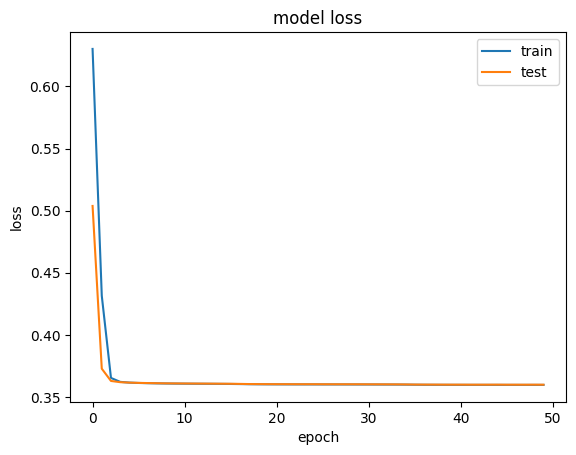

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [29]:
# X_test 값을 넣어서 Reconstruction Error 값을 얻고,
# 실제 레이블인 y_test와 데이터프레임으로 구성
# Reconstruction Error + 실제 레이블의 형태가 됨

predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

2147/2147 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


,reconstruction_error
count,68684.000000
mean,0.588794
std,0.802547
min,0.000141
25%,0.105376
50%,0.334847
75%,0.803627
max,9.616547


In [50]:
error_df['numeric_true_class'] = error_df['true_class'].apply(lambda x: 0 if x == 'Walking' else 1)

print("\n--- numeric_true_class 생성 확인 ---")
print(error_df.head())


--- numeric_true_class 생성 확인 ---
        reconstruction_error  true_class  numeric_true_class  true_class_num
220428              0.223211    Upstairs                   1             NaN
325951              0.058654     Walking                   0             NaN
191045              0.342310     Walking                   0             NaN
161736              0.236602  Downstairs                   1             NaN
120870              1.319086     Jogging                   1             NaN


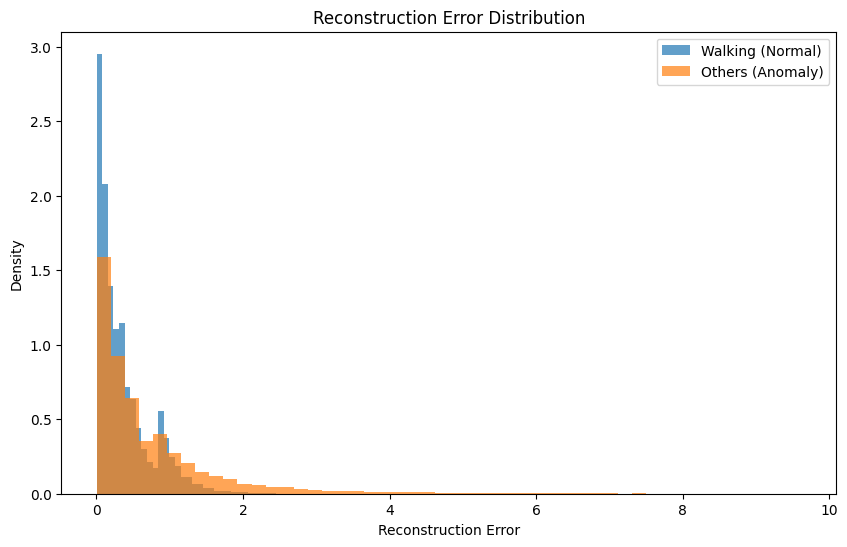

In [51]:
normal_error_df = error_df[error_df['true_class'] == 'Walking']
anomaly_error_df = error_df[error_df['true_class'] != 'Walking']

plt.figure(figsize=(10, 6))
plt.hist(normal_error_df.reconstruction_error, bins=50, density=True, label='Walking (Normal)', alpha=0.7)
plt.hist(anomaly_error_df.reconstruction_error, bins=50, density=True, label='Others (Anomaly)', alpha=0.7)
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.show()

In [52]:
threshold = 1.0
print(f"\n설정된 임계값 (Threshold): {threshold}")


설정된 임계값 (Threshold): 1.0


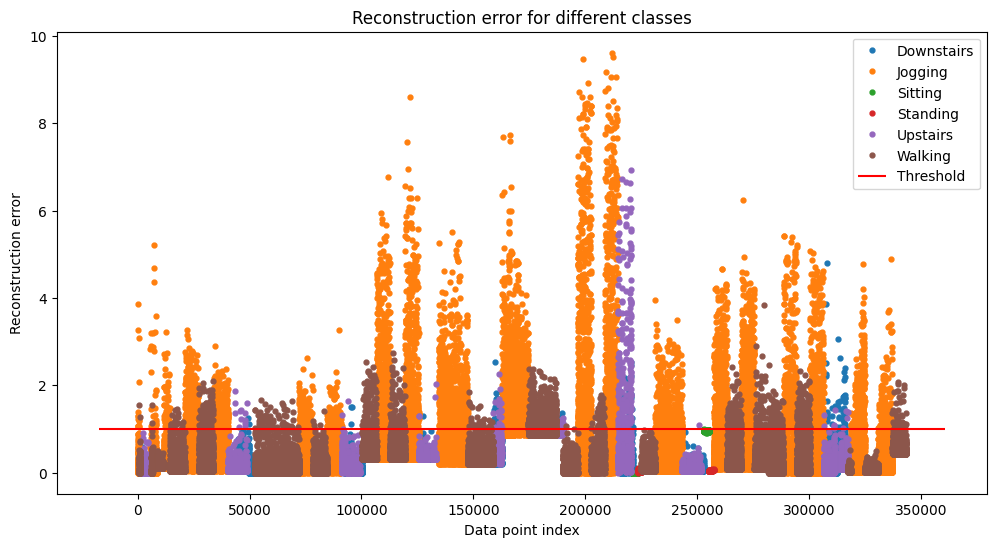

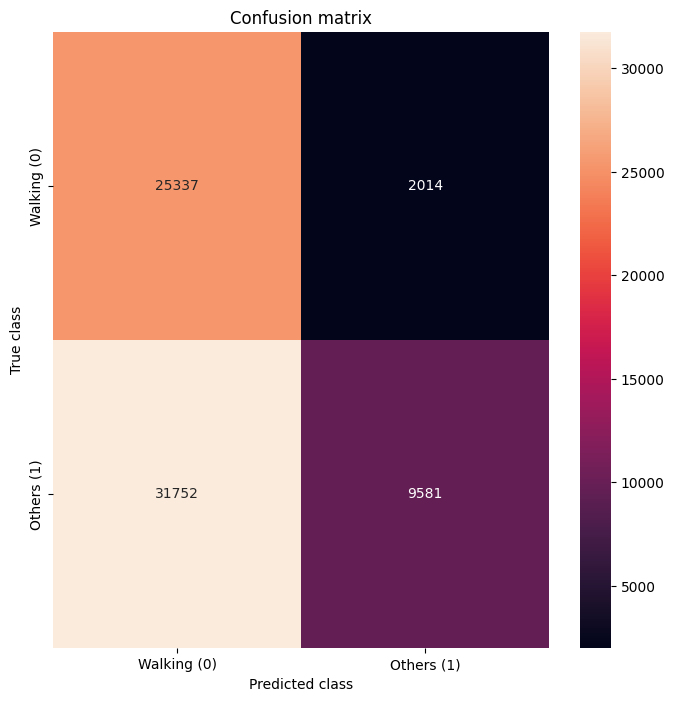

In [53]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(12, 6))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label=name)
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

# ===>>> 수정 4: 예측 및 실제 값 설정 수정 <<<===
# 예측: threshold를 기준으로 0 (Normal) 또는 1 (Anomaly)로 변환
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

# 실제: 문자열('true_class')이 아닌, 방금 만든 숫자형('numeric_true_class') 열 사용
y_true = error_df.numeric_true_class

# 혼동 행렬(Confusion Matrix) 계산
conf_matrix = confusion_matrix(y_true, y_pred)

# 이진 분류 레이블 ('Walking' = 0, 'Others' = 1)
binary_labels = ['Walking (0)', 'Others (1)']

# 혼동 행렬 시각화
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=binary_labels, yticklabels=binary_labels, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [54]:
print("\n--- 분류 리포트 (Classification Report) ---")
# UndefinedMetricWarning은 한 클래스(이 경우 0)의 샘플이 없거나 예측이 전혀 없을 때 발생할 수 있습니다.
# 하지만 threshold를 1.0으로 설정하면 양쪽 다 예측되므로 경고가 사라질 수 있습니다.
print(classification_report(y_true, y_pred, target_names=binary_labels, zero_division=0))


--- 분류 리포트 (Classification Report) ---
              precision    recall  f1-score   support

 Walking (0)       0.44      0.93      0.60     27351
  Others (1)       0.83      0.23      0.36     41333

    accuracy                           0.51     68684
   macro avg       0.64      0.58      0.48     68684
weighted avg       0.67      0.51      0.46     68684

